<a href="https://colab.research.google.com/github/FranciscoLuna/curso_ICE_STM32CUBEIDE/blob/master/MNIST_y_ANN_Entrenamiento_evaluacion_y_descarga_version_TF_donwngrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install q tensorflow==2.1

     |████████████████████████████████| 421.8MB 38kB/s 
     |████████████████████████████████| 3.9MB 39.2MB/s 
     |████████████████████████████████| 450kB 29.2MB/s 
     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=d287abf311b80b5dbc1e614558a717a5523b4c704573c0057fb865e83df8c939
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

# Clasificación de números manuscritos con Redes Neuronales Artificiales (ANN)

En este cuaderno vamos a entrenar un modelo de Percentrón Multicapa para que reconozca números escritos de un sólo dígito. Para ello, vamos a usar el conjunto de datos (o dataset) clásico de MNIST. 

In [ ]:
# Antes de nada, importamos las librerías que nos puedan hacer falta

import tensorflow as tf # Para crear modelos de Aprendizaje Profundo 

import matplotlib.pyplot as plt # Para graficar imágenes y gráficas de evaluación

import numpy as np # Nos permite trabajar con estructuras vectoriales eficientes
                   # que son además las que emplea tensorflow 

import math # Operaciones matemáticas

# métodos para calcular métricas y matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report 

import itertools # funciones eficientes sobre elementos iterables

In [ ]:
print(tf.keras.__version__)

2.2.4-tf


## El dataset MNIST

Este dataset puede considerarse uno de los primeros recursos empleados para sentar las bases del Aprendizaje Profundo o Deep Learning. Contiene varias muestras de dígitos escritos de forma manuscrita, que han sido digitalizados en imágenes de 28x28. 

Este dataset está disponible para su descarga desde la API de tensorflow, de modo que es muy accesible y flexible, ideal para comenzar a probar modelos de Aprendizaje Automático.

In [ ]:
# Creamos el objeto necesario para extraer el dataset
mnist = tf.keras.datasets.mnist

# Para llevar a cabo un entrenamiento y comprobar su efectividad, el modo más 
# simple es dividir el conjunto de datos en subconjuntos de entrenamiento y prueba.
# El metodo load_data sin parámetros divide el conjunto de esta forma, separando 
# además lo que son las entradas (las imagenes 28x28) de las etiquetas (el 
# dígito -0 al 9- que queda representado en la imagen)
(x_train, y_train), (x_test, y_test) = mnist.load_data()


n_samples_train = len(x_train)
n_samples_test = len(x_test)
n_samples = n_samples_train + n_samples_test
print("La relación de muestras entre los dos subconjuntos es del {:.2%} en " 
        "subconjunto de entrenamiento y del {:.2%}, de prueba".format(
            n_samples_train/n_samples, n_samples_test/n_samples))


# Las imágenes están en escala de grises, con una resolución de 256 valores. Es
# común en problemas de clasificación realizar una normalización y escalar ese
# rango de valores al intervalo [0,1], si bien no es necesario. Puede probarse el
# realizar el entrenamiento sin hacer esta conversión.
x_train, x_test = x_train / 255.0, x_test / 255.0


11493376/11490434 [==============================] - 0s 0us/step
La relación de muestras entre los dos subconjuntos es del 85.71% en subconjunto de entrenamiento y del 14.29%, de prueba


In [ ]:
# Una pequeña función para graficar muestras aleatorias

def random_mnist_sample_plot(n_samples, mnist_set):

  rnd_index = np.random.choice(mnist_set.shape[0], size=(n_samples,), replace=False)
  subset = mnist_set[rnd_index]

  grid_width = 5
  grid_length = math.ceil(n_samples/grid_width)
  
  plt.figure(figsize=(15,10)) # specifying the overall grid size

  for i in range(n_samples):
      plt.subplot(grid_length,grid_width,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(subset[i], cmap='gray')

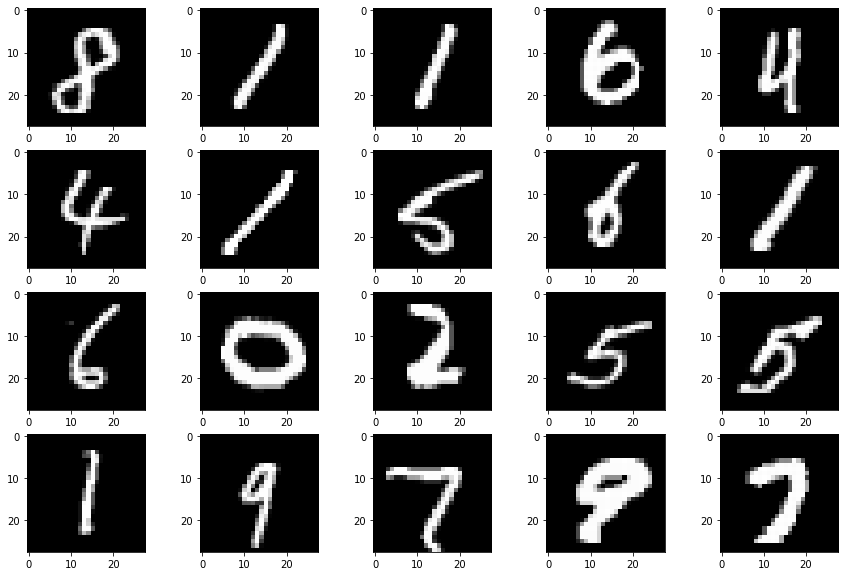

In [ ]:
# Una muestra del MNIST
random_mnist_sample_plot(20, x_train)

Algunas de las muestras pueden ser complicadas de identificar su dígito incluso para una persona. Este problema tiene por ello cierta dificultad y es perfecto para probar el comportamiento y efectividad de modelos de Aprendizaje Profundo.

## Un modelo de Red Neuronal Artificial sencillo

Vamos a crear un modelo sencillo con el que trabajar. No pretendemos alcanzar el máximo rendimiento, sino ejemplificar todo el proceso de creación, entrenamiento, validación y descarga de un modelo. Por ello, no entraremos en detalle sobre parámetros de entrenamiento ni nos dedicaremos a hacer un procesamiento de análisis y optimización exhaustivo.

Los modelos básicos pueden crearse con las clases de la librería de alto nivel Keras, integrado en la propia librería de Tensorflow desde su versión 2.0. Los modelos más típicos son los que "apilan" capas de forma sucesiva (propiedad que coincide con una Red Neuronal Multicapa tradicional). Esto puede realizarse a partir de `tf.keras.Sequential`. 

In [ ]:

"""
# Esta es una forma "compacta" de crear un modelo secuencia con una sola línea.

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

"""

# Modelo creado añadiendo capas progresivamente, equivalente al anterior

model = tf.keras.models.Sequential() # El modelo secuencial vacio inicialmente

model.add(tf.keras.Input(shape=(28, 28))) # Podemos describir la forma de la entrada
                                          # como si de una capa se tratase. 
model.add(tf.keras.layers.Flatten()) # Esta capa "aplana" la imagen, es decir, pasa
                                     # la matriz de valores a un vector unidimensional.
model.add(tf.keras.layers.Dense(128, activation='relu')) # Una capa Densa o Fully-Connected.
model.add(tf.keras.layers.Dropout(0.2)) # Empleamos Dropout, una técnica que inhabilita 
                                        # un % de nodos de la capa anterior de forma aleatoria
                                        # durante el entrenamiento, que ayuda a la generalización
                                        # del modelo evitando el sobre ajuste de los nodos a los
                                        # ejemplos particulares usados.
model.add(tf.keras.layers.Dense(10, activation='softmax')) # Una última capa Densa, ya como salida.
                                                           # Se la ha dotado de 10 nodos, tantos como
                                                           # dígitos diferentes consideramos para su 
                                                           # clasificación (0 al 9)


In [ ]:
model.summary() # Con este método podemos comprobar que nuestra red tiene las 
                # capas añadidas y ver alguna información adicional

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

Elegimos un optimizador y una funcion de perdida para el entrenamiento del modelo.

In [ ]:
# El modelo se inicializa para su entrenamiento con el método compile
# El loss SparseCategoricalCrossEntropy permite introducir las etiquetas sin
# necesidad de codificarlas en One-Hot
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Finalmente, procedemos al entrenamiento del modelo

In [ ]:
# Con este método del modelo podemos entrenarlo. El parámetro "validation_data"
# es opcional y simplemente evalúa el modelo con los datos proporcionados en cada
# época, pero no serán empleados para el entrenamiento (en nuestro caso, le hemos
# proporcionado el subconjunto de prueba)
model.fit(x_train, y_train, validation_data=(x_test, y_test),  epochs=20)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 140us/sample - loss: 0.3011 - accuracy: 0.9112 - val_loss: 0.1416 - val_accuracy: 0.9609
Epoch 2/20
60000/60000 [==============================] - 7s 112us/sample - loss: 0.1458 - accuracy: 0.9567 - val_loss: 0.1114 - val_accuracy: 0.9683
Epoch 3/20
60000/60000 [==============================] - 7s 110us/sample - loss: 0.1120 - accuracy: 0.9661 - val_loss: 0.0876 - val_accuracy: 0.9739
Epoch 4/20
60000/60000 [==============================] - 7s 117us/sample - loss: 0.0910 - accuracy: 0.9722 - val_loss: 0.0824 - val_accuracy: 0.9741
Epoch 5/20
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0778 - accuracy: 0.9760 - val_loss: 0.0879 - val_accuracy: 0.9722
Epoch 6/20
60000/60000 [==============================] - 7s 113us/sample - loss: 0.0672 - accuracy: 0.9786 - val_loss: 0.0806 - val_accuracy: 0.9753
Epoch 7/20
60000/60000 [==========================

### Evaluando el modelo

El modo más básico de evaluar un modelo de clasificación es a partir de la métrica de precisión o accuracy. 

In [ ]:
# Cálculo de la precisión con el método evaluate del modelo, empleando el subconjunto de prueba
model.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 1s - loss: 0.0836 - accuracy: 0.9817


[0.08364677021316384, 0.9817]

Se pueden emplear otro tipo de métricas. Podemos obtener algunas con la ayuda de la librería para Inteligencia Artificial Scikit Learn

In [ ]:
def otras_metricas(logits, ground_truth, classes):
  logits = np.argmax(logits, axis=1)
  print(classification_report(ground_truth, logits,
                              target_names=classes))

In [ ]:
# Llamamos al modelo para que calcule las clasificaciones con el subconjunto de
# prueba
predicts = model.predict(x_test)

# Hallamos las métricas
otras_metricas(predicts, y_test, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



No obstante, si es interesante saber que la mayor parte de estas métricas se calculan a partir de datos que quedan reflejados en lo que es denominado una **matriz de confusión**, la cual ilustra la cantidad de aciertos y fallos cometidos por el modelo, de forma desglosada. 

Vamos a mostrar esta matriz para el modelo entrenado.

In [ ]:
# Función que convierte las salidas del modelo en una clase, para que pueda ser 
# asimilado por la función de cálculo de la matriz de confusión de SciKit Learn
def confusion_matrix_v2(logits, ground_truth):
  
  logits = np.argmax(logits, axis=1)
  
  cm = confusion_matrix(ground_truth, logits)

  return cm


# Una función para hacer más atractiva e intuitiva la matriz de confusión
def plot_pretty_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.rcParams["figure.figsize"] = (len(classes),len(classes))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Etiquetas del dataset')
  plt.xlabel('Predicciones/clasificación del modelo')


Normalized confusion matrix


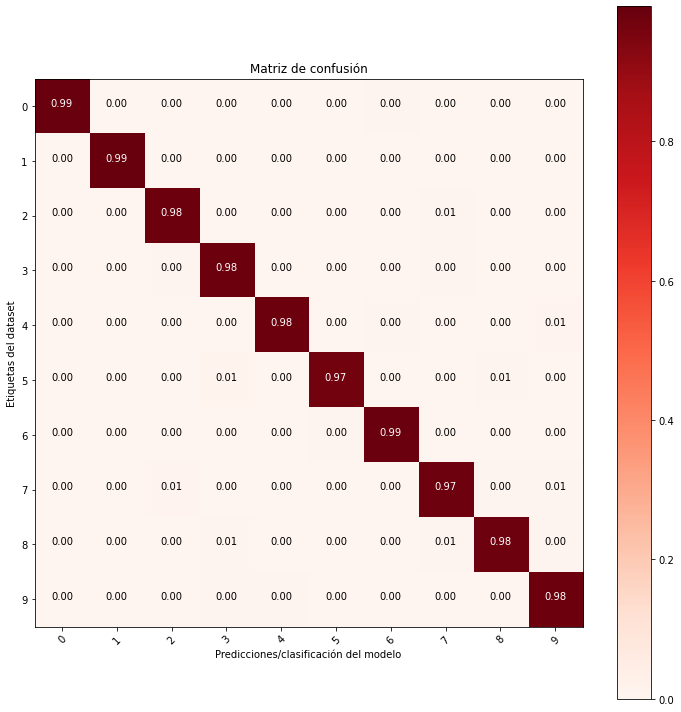

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm = confusion_matrix_v2(predicts, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

### Descarga del modelo

El modelo generado puede descargarse, para luego volver a ser cargado y/o usado en otros entornos, para seguir entrenándolo, manipularlo, hacer uso del mismo en un entorno ya desplegado como servicio, etc. 

In [ ]:
# Guardando el modelo (tanto el modelo en sí junto con sus parámetros como los pesos)

# model.save('mnist_full_model') # Si no se indica extensión, el modelo se 
                                 # guardará en una carpeta con una serie de 
                                 # ficheros, entre ellos el modelo en si con 
                                 # formato protobuf (.pb)

model.save('mnist_full_model.h5') # Si se especifica esta extensión, el modelo
                                   # queda guardado en un fichero HDF5, propio 
                                   # de Keras. 

# Guardado de únicamente los pesos del modelo
model.save_weights('mnist_model_weights')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mnist_full_model/assets


In [ ]:
# Para poder descargar la carpeta con el modelo protobuf, la comprimimos

!zip -r mnist_full_model.zip mnist_full_model

  adding: mnist_full_model/ (stored 0%)
  adding: mnist_full_model/saved_model.pb (deflated 88%)
  adding: mnist_full_model/variables/ (stored 0%)
  adding: mnist_full_model/variables/variables.data-00000-of-00002 (deflated 76%)
  adding: mnist_full_model/variables/variables.index (deflated 58%)
  adding: mnist_full_model/variables/variables.data-00001-of-00002 (deflated 14%)
  adding: mnist_full_model/assets/ (stored 0%)


- **Probamos a cargar el modelo**

In [ ]:
# Carga del modelo de Keras, y de nuevo calculamos la precisión para comprobar 
# de forma simple que el modelo no haya sido perturbado

model_returns = tf.keras.models.load_model('mnist_full_model.h5')


model_returns.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 1s - loss: 0.0836 - accuracy: 0.9817


[0.08364677021316384, 0.9817]

Probablemente la precisión resultante sea completamente diferente (posiblemente desastrosa). ¿Por qué? Sencillamente porque, aunque el modelo y sus pesos se guardan intactos, no queda guardado absolutamente todo. Entre otras cosas, algunos parámetros de entrenamiento y evaluación no han quedado almacenados y, si no se especifica de nuevo, los métodos de evaluación pueden no ser coherentes con el modo en cómo se entrenó y evaluó el modelo. 

Para este caso, simplemente vamos a repetir la fase de "compilación" del modelo (que realmente no es una compilación per se, se trata de una configuración de los métodos relacionados con el entrenamiento y métricas de evaluación).

In [ ]:
# Entre otras cosas, añadimos la métrica de precisión de nuevo, para que funcione
# correctamente el método de evaluación.
model_returns.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_returns.evaluate(x_test,  y_test, verbose=2)

10000/10000 - 1s - loss: 0.0836 - accuracy: 0.9817


[0.08364677021316384, 0.9817]

## Cuantización del modelo

Los modelos de Deep Learning son computacionalmente muy costosos. Consumen gran cantidad de recursos, lo que repercute en los tiempos de ejecución e incluso imposibilita su ejecución en computadores de bajas prestaciones. 

Una de las técnicas que pretenden paliar este hecho en cierta medida es la cuantización de un modelo. Consiste dicho de forma simplificada en disminuir la 
resolución de los parámetros del modelo (o incluso adicionalmente los datos de entrada), para así poder ser soportadas por computadores cuya bajada de resolución le permita trabajar con el modelo y operar de forma más eficiente. 

La principal consecuencia de este cambio de resolución es que la efectividad del modelo puede verse mermada. No obstante, dadas las particularidades de las arquitecturas de Aprendizaje Profundo, con tantos parámetros el modelo resultante tiende a ser robusto y no perder demasiada precisión cuando se realiza esta conversión. Existen además distintas técnicas de cuantización para paliar en mayor cuantía esta disminución en la efectividad del modelo, que como suele ser habitual va de la mano de una mayor complejidad en el procedimiento de cuantización. En esta sección veremos algunos métodos simples y compararemos la efectividad con el modelo original sin cuantizar. 

### TF-Lite: la sublibrería de TF que permite la cuantización

TF-Lite son un conjunto de herramientas, en forma de funciones, contenidos en la librería TensorFlow cuyo propósito es transformar los modelos de Aprendizaje Profundo para que sean asimilables por computadores de prestaciones más humildes, como móviles con procesadores y gráficas que no tienen la arquitectura NVIDIA, o microcontroladores, entre otros. 

### **Diferentes modos de conversión**

In [ ]:
# Cargamos el modelo generado previamente

clasical_model = tf.keras.models.load_model('mnist_full_model.h5')

- #### **Conversión básica**

Una vez generado y cargado el modelo, creamos el conversor y con él convertimos el modelo:

In [ ]:
# Creamos el conversor
converter = tf.lite.TFLiteConverter.from_keras_model(clasical_model)

# Creamos el modelo de TFLite a partir del conversor
tflite_model = converter.convert()

In [ ]:
with open('mnist_basic_float_model.tflite', 'wb') as f:
  f.write(tflite_model)

La conversión que se ha hecho es muy básica, usando los parámetros por defecto con los que se configura el conversor. Según el dispositivo en el que se pretenda integrar el modelo como predictor/clasificador, la configuración deberá variar para adaptar el modelo a las características del hardware.

A partir de ahora, nos vamos a centrar en reducir los pesos y demás parámetros del modelo en una resolución de integer de 8 bits.

- #### **Conversión con cuantización a 8bits (post-training quantization)**


1. **Dynamic range quantization** 

El siguiente ejemplo ilustra el modo más básico para hacer una cuantización (dynamic range quantization).

In [ ]:
# Creamos el conversor
converter = tf.lite.TFLiteConverter.from_keras_model(clasical_model)
# Variamos la configuración, con esta sentencia configuramos el conversor para que cuantice a 8bits
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Creamos el modelo de TFLite a partir del conversor
tflite_quant_model = converter.convert()

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


# print('input_details: ', input_details)
# print('output_details: ', output_details)


# Test the model on random input data.
input_shape = input_details[0]['shape']

# Es necesario que tanto la forma como el tipo de los datos que componen el 
# dataset sean los que admita el modelo TFLite configurado. 
x_test_type_float32 = x_test.astype(np.float32)
#print('Tipo de los datos tras la conversión: ', type(x_test_type_float32[0,0,0]))
input_data = x_test_type_float32

#print('shape', np.shape(input_data))
interpreter.resize_tensor_input(input_details[0]['index'],np.shape(input_data))
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.2566631e-10 1.7622706e-16 2.3251163e-11 ... 9.9999893e-01
  4.7337832e-11 5.9221722e-10]
 [5.1546944e-15 4.3821364e-09 1.0000000e+00 ... 2.3296549e-19
  2.6585045e-12 7.5742347e-25]
 [8.1685908e-12 9.9989581e-01 5.0304720e-07 ... 1.0146804e-04
  1.5853747e-06 2.1575445e-12]
 ...
 [1.1955300e-21 2.5239015e-19 5.7355650e-20 ... 1.0845969e-09
  4.6591064e-12 2.3161899e-08]
 [3.6328360e-20 1.3514612e-21 5.0248896e-21 ... 1.0724173e-16
  8.7437524e-10 3.1211369e-18]
 [1.5543244e-13 3.3786370e-22 4.1415283e-14 ... 7.1372601e-21
  8.6888799e-16 2.3248709e-18]]


In [ ]:
otras_metricas(output_data, y_test, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.96      0.99      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



Normalized confusion matrix


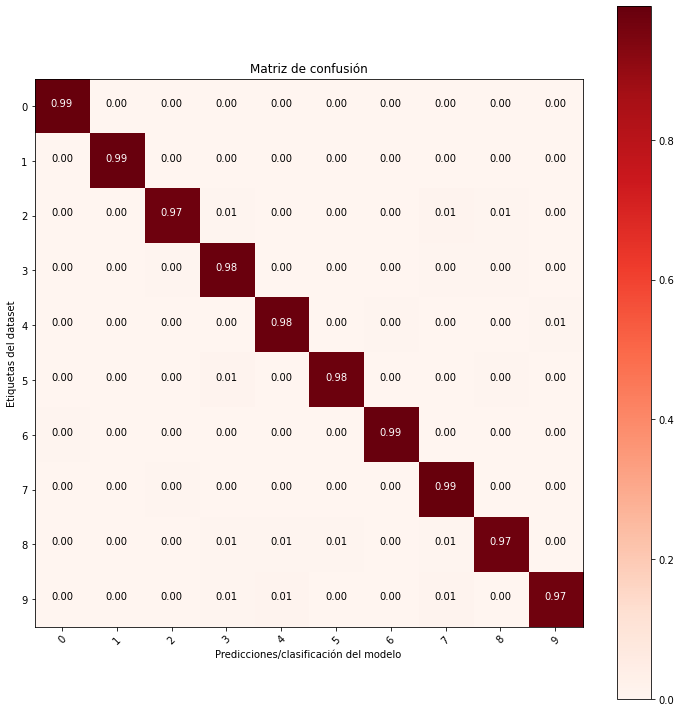

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm = confusion_matrix_v2(output_data, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

In [ ]:
with open('mnist_dynamic_range_quantized_model.tflite', 'wb') as f:
  f.write(tflite_quant_model)

2. **Full integer quantization** 

El modelo anterior, como se ha podido entrever en algunos pasos, aún trabaja con datos a la entrada con coma flotante. Del mismo modo, las salidas del modelo también son en coma flotante. 

Cuantizar completamente un modelo, esto es, convertir entradas y salidas a una resolución reducida apropiada, puede ser necesario (y de hecho lo es en numerosos casos) para ser ejecutados en microcontroladores y otros computadores, como las novedosas Unidades de Procesamiento Tensorial (TPU) del tipo Edge. 

Un modelo previamente entranado puede cuantizarse totalmente haciendo uso de TFLite, pero requiere involucrar datos representativos con los que fue entrenado. Son necesarios (presumiblemente) para un reajuste de los valores de salida respecto de las entradas. De forma resumida, se debe calibrar el rango de activación de los nodos de salida (de inferencia, de clasificación) con respecto a las entradas, por lo que es necesario dar ejemplos representantivos en el proceso de conversión para una correcta calibración.

In [ ]:
# Vamos a usar los datos empleados en el entrenamiento como muestras representativas

representative_input = x_train.astype(np.float32)
# Nótese que no se usan nada más que las entradas. Como se trata de una
# recalibración del modelo para el cambio de resolución, lo que se emplean son 
# las salidas del modelo cuando se le introduce un dato, no las etiquetas que
# usamos como los valores "verdaderos". Es interesante saberlo porque esto implica
# que no tenemos por qué ceñirnos a datos etiquetados para el calibrado, podemos
# usar datos sin etiquetar, los datos de test, o todos a la vez.


In [ ]:
# Para incluir las muestras representativas en el conversor, es necesario 
# proporcionarlas como un generador. Por ello, es necesario crear dicho generador
# que convierta los datos en un formato apropiado.

mnist_ds = tf.data.Dataset.from_tensor_slices((representative_input)).batch(1)

def representative_data_gen():
    #for i in range(len(representative_input)):
    for image in mnist_ds.take(100):
      # image = next(iter(representative_input))
      # image = tf.cast(image / 255., tf.float32) # Esto sería necesario en este
                                                  # caso, porque estamos usando
                                                  # un conjunto con valores y tipo  
                                                  # tal y como los que necesita 
                                                  # el modelo.
      # image = tf.expand_dims(image, 0)          # Igual con esto

      # Se puede poner un print para no estar en incertidumbre. El proceso puede
      # durar según la complejidad del modelo.
      #print('Sample #', image)
      yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(clasical_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
converter.representative_dataset = representative_data_gen

tflite_full_quant_model = converter.convert()

In [ ]:
def adapt_dataset_to_quantized_model(dataset, interpeter_input_details):
    
    # Check if the input type is quantized, then rescale input data to uint8
    if interpeter_input_details['dtype'] == np.uint8:
      print('quantization details: ', interpeter_input_details["quantization"])
      input_scale, input_zero_point = interpeter_input_details["quantization"]
    resulting_dataset = dataset / input_scale + input_zero_point

    resulting_dataset = resulting_dataset.astype(interpeter_input_details["dtype"])

    return resulting_dataset



In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_full_quant_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


print('input_details: ', input_details)
print('output_details: ', output_details)


# Test the model on random input data.
input_shape = input_details[0]['shape']

# Es necesario que tanto la forma como el tipo de los datos que componen el 
# dataset sean los que admita el modelo TFLite configurado. 

# FAIL ROTUNDO: x_test_type_int8 = x_test.astype(np.uint8)

x_test_type_int8 = adapt_dataset_to_quantized_model(x_test, input_details[0])

#print('Tipo de los datos tras la conversión: ', type(x_test_type_float32[0,0,0]))
input_data = x_test_type_int8

#print('shape', np.shape(input_data))
interpreter.resize_tensor_input(input_details[0]['index'],np.shape(input_data))
interpreter.allocate_tensors()

interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

input_details:  [{'name': 'flatten_input', 'index': 10, 'shape': array([ 1, 28, 28], dtype=int32), 'shape_signature': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details:  [{'name': 'Identity', 'index': 11, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


UnboundLocalError: ignored

In [ ]:
otras_metricas(output_data, y_test, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm = confusion_matrix_v2(output_data, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm, classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

In [ ]:
random_mnist_sample_plot(20, x_test_type_int8)

In [ ]:
with open('mnist_full_quant.tflite', 'wb') as f:
  f.write(tflite_full_quant_model)

# Nueva sección